In [2]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")



INFO:__main__:Loading cached data...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-11-04 00:00:02+00:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [1.0, 338.0, 1.0, 404.0, 0.0, 382.0, 2.0, 436.0, 1.0, 416.0, 1.0, 385.0, 0.0, 393.0]
caps:  [1.0, 338.0, 1.0, 404.0, 0.0, 382.0, 2.0, 436.0, 1.0, 416.0, 1.0, 385.0, 0.0, 393.0]
boxes:  [31.0, 29.0, 42.0, 44.0, 36.0, 30.0, 36.0]
medians:  [67.0, 78.0, 86.0, 90.0, 81.0, 70.0, 81.0]
means:  [155.92442182001005, 158.88481403767668, 169.4802347370429, 182.92806347534076, 208.83867942434156, 179.28833430742256, 157.75941854877462]
fliers:  []


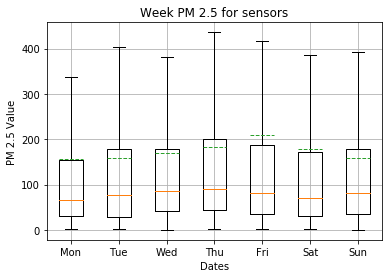

In [3]:
# Day - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = data[(data.index.day_name() == 'Monday')].between_time('15:00:00', '01:00:00')['pm2_5']
tuesday = data[data.index.day_name() == 'Tuesday'].between_time('15:00:00', '01:00:00')['pm2_5']
wednesday = data[data.index.day_name() == 'Wednesday'].between_time('15:00:00', '01:00:00')['pm2_5']
thursday = data[data.index.day_name() == 'Thursday'].between_time('15:00:00', '01:00:00')['pm2_5']
friday = data[data.index.day_name() == 'Friday'].between_time('15:00:00', '01:00:00')['pm2_5']
saturday = data[data.index.day_name() == 'Saturday'].between_time('15:00:00', '01:00:00')['pm2_5']
sunday = data[data.index.day_name() == 'Sunday'].between_time('15:00:00', '01:00:00')['pm2_5']
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./weely_hybrid_day_boxplot_pm_2_5/weely_hybrid_day_boxplot_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [45.0, 439.0, 2.0, 167.0, 178.0, 768.0, 2.0, 267.0, 3.0, 114.0, 2.0, 147.0, 7.0, 339.0, 1.0, 190.0, 5.0, 704.0, 8.0, 748.0, 2.0, 162.0, 9.0, 68.0, 4.0, 385.0, 5.0, 359.0, 35.0, 169.0, 4.0, 219.0, 2.0, 232.0, 4.0, 484.0, 4.0, 153.0, 6.0, 339.0]
caps:  [45.0, 439.0, 2.0, 167.0, 178.0, 768.0, 2.0, 267.0, 3.0, 114.0, 2.0, 147.0, 7.0, 339.0, 1.0, 190.0, 5.0, 704.0, 8.0, 748.0, 2.0, 162.0, 9.0, 68.0, 4.0, 385.0, 5.0, 359.0, 35.0, 169.0, 4.0, 219.0, 2.0, 232.0, 4.0, 484.0, 4.0, 153.0, 6.0, 339.0]
boxes:  [142.0, 17.0, 398.0, 40.0, 14.0, 30.0, 24.0, 25.0, 59.0, 83.0, 25.0, 23.0, 35.0, 40.0, 57.0, 35.0, 32.0, 59.0,

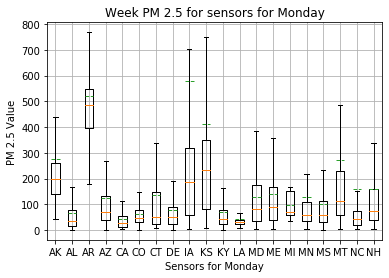

whiskers:  [25.0, 539.0, 4.0, 257.0, 4.0, 929.0, 2.0, 387.0, 1.0, 151.0, 2.0, 156.0, 4.0, 264.0, 2.0, 229.0, 13.0, 556.0, 25.0, 792.0, 3.0, 189.0, 4.0, 23.0, 2.0, 414.0, 5.0, 508.0, 10.0, 280.0, 4.0, 278.0, 3.0, 323.0, 4.0, 422.0, 3.0, 151.0, 6.0, 475.0]
caps:  [25.0, 539.0, 4.0, 257.0, 4.0, 929.0, 2.0, 387.0, 1.0, 151.0, 2.0, 156.0, 4.0, 264.0, 2.0, 229.0, 13.0, 556.0, 25.0, 792.0, 3.0, 189.0, 4.0, 23.0, 2.0, 414.0, 5.0, 508.0, 10.0, 280.0, 4.0, 278.0, 3.0, 323.0, 4.0, 422.0, 3.0, 151.0, 6.0, 475.0]
boxes:  [172.0, 12.0, 272.0, 27.0, 11.0, 44.0, 24.0, 22.0, 41.0, 241.0, 14.0, 8.0, 59.0, 33.0, 52.0, 42.0, 31.0, 40.0, 16.0, 63.0]
medians:  [216.0, 52.0, 477.0, 82.0, 28.0, 57.0, 64.0, 47.0, 137.0, 348.0, 42.0, 10.0, 122.0, 87.0, 102.0, 87.0, 69.0, 101.0, 30.0, 112.0]
means:  [290.0586156724174, 80.77147181233447, 468.27852954442943, 108.8067335243553, 49.40110932710553, 81.49594272076372, 124.08580425085279, 77.4850240180842, 205.80268784361638, 1048.069639584606, 56.54070265638389, 19.5

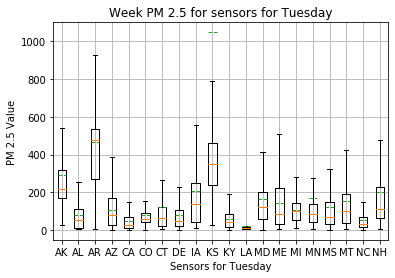

whiskers:  [0.0, 492.0, 5.0, 174.0, 104.0, 864.0, 3.0, 295.0, 2.0, 143.0, 4.0, 161.0, 4.0, 259.0, 4.0, 236.0, 9.0, 452.0, 17.0, 1092.0, 2.0, 170.0, 3.0, 232.0, 2.0, 438.0, 6.0, 467.0, 19.0, 293.0, 5.0, 313.0, 0.0, 344.0, 3.0, 403.0, 4.0, 169.0, 12.0, 286.0]
caps:  [0.0, 492.0, 5.0, 174.0, 104.0, 864.0, 3.0, 295.0, 2.0, 143.0, 4.0, 161.0, 4.0, 259.0, 4.0, 236.0, 9.0, 452.0, 17.0, 1092.0, 2.0, 170.0, 3.0, 232.0, 2.0, 438.0, 6.0, 467.0, 19.0, 293.0, 5.0, 313.0, 0.0, 344.0, 3.0, 403.0, 4.0, 169.0, 12.0, 286.0]
boxes:  [177.0, 22.0, 389.0, 48.0, 16.0, 49.0, 39.0, 39.0, 51.0, 56.0, 22.75, 37.0, 62.0, 57.0, 67.25, 38.0, 44.0, 42.0, 31.0, 56.0]
medians:  [239.0, 47.0, 503.0, 89.0, 41.0, 66.0, 72.0, 80.0, 120.0, 285.0, 50.0, 70.5, 123.0, 114.0, 131.0, 81.0, 95.0, 99.0, 61.0, 92.0]
means:  [273.5071719497078, 71.87777777777778, 608.7253317945759, 105.55540030739137, 52.92111923509561, 101.26603098927295, 135.10233496684924, 107.11672498250525, 274.9950273495773, 828.2187004754359, 61.19472222222

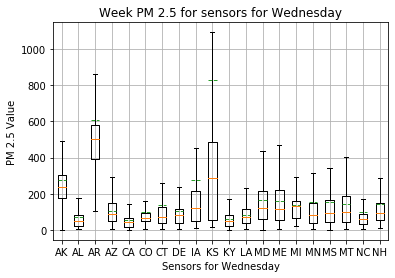

whiskers:  [56.0, 604.0, 4.0, 212.0, 206.0, 902.0, 2.0, 302.0, 3.0, 151.0, 3.0, 146.0, 10.0, 290.0, 5.0, 225.0, nan, nan, 2.0, 504.0, 18.0, 917.0, 2.0, 234.0, 11.0, 171.0, 3.0, 411.0, 10.0, 562.0, 72.0, 2013.0, 3.0, 396.0, 5.0, 309.0, 5.0, 311.0, 8.0, 148.0, 6.0, 921.0]
caps:  [56.0, 604.0, 4.0, 212.0, 206.0, 902.0, 2.0, 302.0, 3.0, 151.0, 3.0, 146.0, 10.0, 290.0, 5.0, 225.0, nan, nan, 2.0, 504.0, 18.0, 917.0, 2.0, 234.0, 11.0, 171.0, 3.0, 411.0, 10.0, 562.0, 72.0, 2013.0, 3.0, 396.0, 5.0, 309.0, 5.0, 311.0, 8.0, 148.0, 6.0, 921.0]
boxes:  [216.0, 25.0, 455.0, 50.0, 19.0, 49.0, 45.0, 41.5, nan, 30.0, 348.0, 27.0, 41.0, 57.0, 68.0, 208.0, 36.0, 62.0, 40.0, 36.0, 38.0]
medians:  [264.0, 47.0, 521.0, 85.0, 39.0, 61.0, 86.0, 74.0, nan, 67.0, 400.0, 52.0, 66.0, 118.0, 140.0, 322.0, 110.0, 97.5, 92.0, 59.0, 84.5]
means:  [328.00703834043344, 65.79296740994855, 588.7339186223197, 106.2897964873153, 58.9476097832129, 73.99304174950298, 169.01648009950247, 87.58271362424583, nan, 152.6632041550

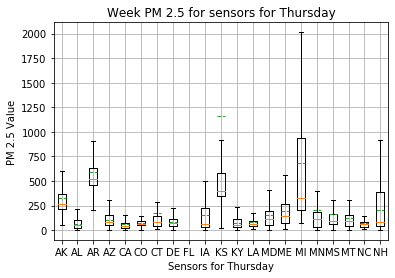

whiskers:  [59.0, 576.0, 3.0, 196.0, 259.0, 771.0, 3.0, 308.0, 1.0, 151.0, 3.0, 179.0, 7.0, 323.0, 8.0, 225.0, 7.0, 448.0, 28.0, 1230.0, 1.0, 254.0, 3.0, 161.0, 5.0, 469.0, 5.0, 469.0, 101.0, 324.0, 2.0, 298.0, 5.0, 237.0, 2.0, 381.0, 9.0, 140.0, 9.0, 702.0]
caps:  [59.0, 576.0, 3.0, 196.0, 259.0, 771.0, 3.0, 308.0, 1.0, 151.0, 3.0, 179.0, 7.0, 323.0, 8.0, 225.0, 7.0, 448.0, 28.0, 1230.0, 1.0, 254.0, 3.0, 161.0, 5.0, 469.0, 5.0, 469.0, 101.0, 324.0, 2.0, 298.0, 5.0, 237.0, 2.0, 381.0, 9.0, 140.0, 9.0, 702.0]
boxes:  [200.0, 19.0, 451.0, 36.0, 14.0, 42.0, 37.0, 28.0, 53.0, 82.0, 23.0, 30.0, 52.0, 47.0, 156.0, 31.0, 32.0, 39.0, 28.0, 57.0]
medians:  [254.0, 41.0, 504.0, 72.0, 37.0, 68.0, 66.0, 57.0, 100.0, 334.0, 47.0, 51.0, 113.0, 116.0, 189.0, 73.0, 63.0, 88.0, 39.0, 143.0]
means:  [293.8256834289571, 60.07802197802198, 510.3261488409923, 96.19867748722572, 52.102387028974626, 105.00822875951451, 117.77574243685817, 90.64170960897242, 282.28458333333333, 2821.7166582788122, 73.90688705

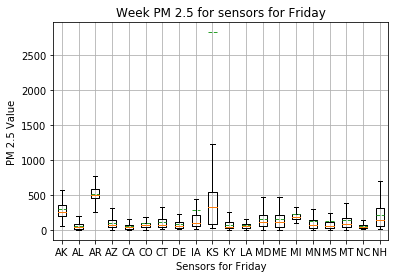

whiskers:  [30.0, 463.0, 2.0, 205.0, 322.0, 701.0, 3.0, 318.0, 1.0, 130.0, 3.0, 165.0, 7.0, 222.0, 4.0, 245.0, 7.0, 260.0, 8.0, 659.0, 3.0, 226.0, 2.0, 157.0, 2.0, 503.0, 4.0, 572.0, 52.0, 825.0, 3.0, 357.0, 3.0, 328.0, 2.0, 366.0, 2.0, 162.0, 8.0, 339.0]
caps:  [30.0, 463.0, 2.0, 205.0, 322.0, 701.0, 3.0, 318.0, 1.0, 130.0, 3.0, 165.0, 7.0, 222.0, 4.0, 245.0, 7.0, 260.0, 8.0, 659.0, 3.0, 226.0, 2.0, 157.0, 2.0, 503.0, 4.0, 572.0, 52.0, 825.0, 3.0, 357.0, 3.0, 328.0, 2.0, 366.0, 2.0, 162.0, 8.0, 339.0]
boxes:  [128.0, 13.0, 464.0, 35.0, 15.0, 43.0, 32.0, 23.0, 19.0, 39.0, 16.0, 19.0, 51.0, 35.0, 145.0, 34.0, 30.0, 24.0, 17.0, 43.0]
medians:  [207.0, 40.0, 498.0, 69.0, 34.0, 56.0, 66.0, 55.0, 40.0, 90.0, 36.0, 35.0, 131.0, 96.5, 227.0, 62.0, 74.0, 64.0, 36.0, 70.0]
means:  [221.255384063173, 78.98065047344586, 500.1540999057493, 96.47619047619048, 44.73439393939394, 115.83645833333334, 113.54614733276884, 127.40546314665039, 102.54032258064517, 1645.1487910725357, 62.584619866006406, 50

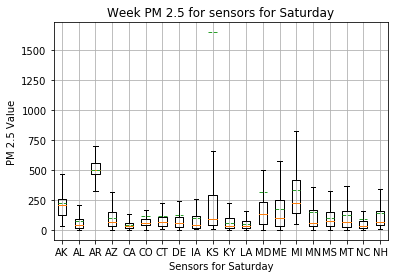

whiskers:  [0.0, 481.0, 1.0, 229.0, 205.0, 872.0, 2.0, 269.0, 1.0, 154.0, 4.0, 119.0, 7.0, 212.0, 4.0, 198.0, 4.0, 653.0, 0.0, 340.0, 1.0, 235.0, 5.0, 127.0, 1.0, 512.0, 3.0, 504.0, 44.0, 521.0, 3.0, 299.0, 3.0, 378.0, 2.0, 548.0, 2.0, 203.0, 8.0, 310.0]
caps:  [0.0, 481.0, 1.0, 229.0, 205.0, 872.0, 2.0, 269.0, 1.0, 154.0, 4.0, 119.0, 7.0, 212.0, 4.0, 198.0, 4.0, 653.0, 0.0, 340.0, 1.0, 235.0, 5.0, 127.0, 1.0, 512.0, 3.0, 504.0, 44.0, 521.0, 3.0, 299.0, 3.0, 378.0, 2.0, 548.0, 2.0, 203.0, 8.0, 310.0]
boxes:  [149.0, 17.0, 455.0, 37.0, 14.0, 47.0, 25.0, 28.0, 62.0, 84.0, 31.0, 22.0, 52.0, 56.0, 183.0, 32.0, 28.0, 58.0, 26.0, 43.0]
medians:  [207.0, 42.0, 503.0, 67.0, 35.0, 57.0, 50.0, 59.0, 131.0, 125.0, 55.0, 31.0, 116.0, 118.0, 211.5, 73.0, 78.0, 130.0, 56.0, 94.0]
means:  [252.82929664793645, 78.55414012738854, 584.9204383039543, 101.16313462418051, 59.58181818181818, 65.41502296676573, 85.96791907514451, 76.80921351719958, 315.5638936535163, 415.27204374572796, 76.55987361769353, 87

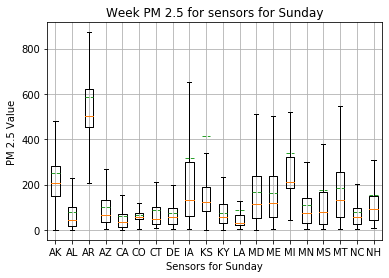

In [31]:
# Day each sensors - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html
import numpy as np
from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
plt.xlabel('Sensors')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])


# for name, sensor_data in data.groupby("name"):
for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = data[data.index.day_name() == day]
    # temp = temp.groupby("name")
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].between_time('15:00:00', '01:00:00').to_numpy().tolist())

    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()

# monday = data[(data.index.day_name() == 'Monday')]
# monday = monday['AK'].between_time('15:00:00', '01:00:00')['pm2_5']

# tuesday = data[data.index.day_name() == 'Tuesday'].between_time('15:00:00', '01:00:00')['pm2_5']
# wednesday = data[data.index.day_name() == 'Wednesday'].between_time('15:00:00', '01:00:00')['pm2_5']
# thursday = data[data.index.day_name() == 'Thursday'].between_time('15:00:00', '01:00:00')['pm2_5']
# friday = data[data.index.day_name() == 'Friday'].between_time('15:00:00', '01:00:00')['pm2_5']
# saturday = data[data.index.day_name() == 'Saturday'].between_time('15:00:00', '01:00:00')['pm2_5']
# sunday = data[data.index.day_name() == 'Sunday'].between_time('15:00:00', '01:00:00')['pm2_5']
# all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

# results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
# plt.savefig("./weely_hybrid_day_boxplot_pm_2_5/weely_hybrid_day_boxplot_pm_2_5.png", format='png')

# print(results)
# print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
# print('caps: ', [item.get_ydata()[1] for item in results['caps']])
# print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
# print('medians: ', [item.get_ydata()[1] for item in results['medians']])
# print('means: ', [item.get_ydata()[1] for item in results['means']])
# print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [0.0, 180.0, 0.0, 198.0, 0.0, 220.0, 0.0, 176.0, 0.0, 283.0, 0.0, 205.0, 0.0, 212.0]
caps:  [0.0, 180.0, 0.0, 198.0, 0.0, 220.0, 0.0, 176.0, 0.0, 283.0, 0.0, 205.0, 0.0, 212.0]
boxes:  [15.0, 11.0, 18.0, 24.0, 18.0, 10.0, 10.0]
medians:  [36.0, 38.0, 41.0, 44.0, 49.0, 28.0, 41.0]
means:  [88.67698344271814, 94.70501197551673, 99.88380365188523, 99.57356279006741, 116.1933871116155, 83.36131563650456, 114.86036558953478]
fliers:  []


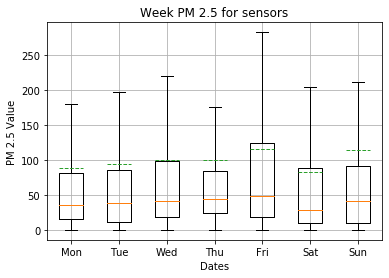

In [42]:
# Night - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

# data.tz_localize('UTC', level=8)

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = data[(data.index.day_name() == 'Monday')].between_time('01:01', '07:59')['pm2_5']
tuesday = data[data.index.day_name() == 'Tuesday'].between_time('01:01', '07:59')['pm2_5']
wednesday = data[data.index.day_name() == 'Wednesday'].between_time('01:01', '07:59')['pm2_5']
thursday = data[data.index.day_name() == 'Thursday'].between_time('01:01', '07:59')['pm2_5']
friday = data[data.index.day_name() == 'Friday'].between_time('01:01', '07:59')['pm2_5']
saturday = data[data.index.day_name() == 'Saturday'].between_time('01:01', '07:59')['pm2_5']
sunday = data[data.index.day_name() == 'Sunday'].between_time('01:01', '07:59')['pm2_5']
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./weely_hybrid_night_boxplot_pm_2_5/weely_hybrid_night_boxplot_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [63.0, 343.0, 1.0, 100.0, 335.0, 725.0, 2.0, 153.0, 0.0, 49.0, 2.0, 62.0, 3.0, 288.0, 2.0, 110.0, 14.0, 276.0, 2.0, 66.0, 1.0, 90.0, 0.0, 46.0, 1.0, 138.0, 2.0, 222.0, 34.0, 137.0, 1.0, 127.0, 3.0, 148.0, 2.0, 139.0, 4.0, 85.0, 3.0, 91.0]
caps:  [63.0, 343.0, 1.0, 100.0, 335.0, 725.0, 2.0, 153.0, 0.0, 49.0, 2.0, 62.0, 3.0, 288.0, 2.0, 110.0, 14.0, 276.0, 2.0, 66.0, 1.0, 90.0, 0.0, 46.0, 1.0, 138.0, 2.0, 222.0, 34.0, 137.0, 1.0, 127.0, 3.0, 148.0, 2.0, 139.0, 4.0, 85.0, 3.0, 91.0]
boxes:  [163.0, 13.0, 482.0, 23.0, 7.0, 11.0, 13.0, 15.0, 49.0, 5.0, 10.25, 3.0, 18.0, 25.0, 51.25, 20.0, 11.0, 12.0, 10.0, 7.0]

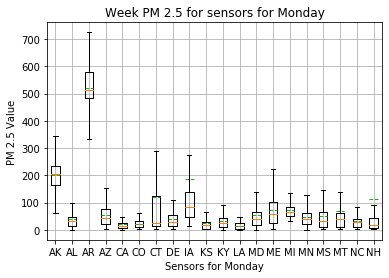

whiskers:  [36.0, 435.0, 0.0, 147.0, 393.0, 625.0, 0.0, 190.0, 0.0, 73.0, 1.0, 115.0, 3.0, 101.0, 1.0, 128.0, 11.0, 229.0, 40.0, 640.0, 3.0, 120.0, 1.0, 93.0, 0.0, 151.0, 0.0, 406.0, 14.0, 73.0, 4.0, 150.0, 0.0, 145.0, 0.0, 192.0, 0.0, 59.0, 3.0, 152.0]
caps:  [36.0, 435.0, 0.0, 147.0, 393.0, 625.0, 0.0, 190.0, 0.0, 73.0, 1.0, 115.0, 3.0, 101.0, 1.0, 128.0, 11.0, 229.0, 40.0, 640.0, 3.0, 120.0, 1.0, 93.0, 0.0, 151.0, 0.0, 406.0, 14.0, 73.0, 4.0, 150.0, 0.0, 145.0, 0.0, 192.0, 0.0, 59.0, 3.0, 152.0]
boxes:  [130.5, 7.0, 478.0, 14.0, 3.0, 10.0, 14.0, 11.0, 17.0, 93.0, 10.0, 4.0, 11.0, 14.0, 19.0, 13.0, 11.0, 10.0, 4.0, 12.0]
medians:  [200.0, 32.0, 512.0, 50.0, 15.0, 24.0, 33.0, 32.0, 74.0, 226.0, 26.0, 15.0, 43.0, 57.0, 33.0, 37.0, 32.0, 50.0, 12.0, 33.0]
means:  [195.3164812942366, 44.876196172248804, 555.3339604891815, 59.62932347182945, 21.494672754946727, 32.74940170940171, 53.712006382130035, 38.39003698063955, 521.3237753882916, 490.38255813953486, 42.36762360446571, 25.5334928229

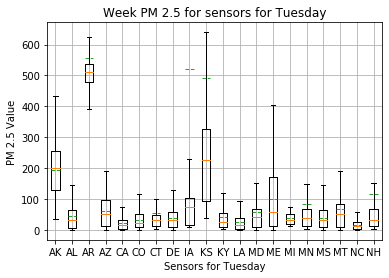

whiskers:  [77.0, 410.0, 3.0, 117.0, 280.0, 706.0, 2.0, 146.0, 0.0, 81.0, 0.0, 134.0, 1.0, 126.0, 1.0, 123.0, 2.0, 224.0, 15.0, 173.0, 2.0, 86.0, 4.0, 15.0, 0.0, 174.0, 1.0, 252.0, 15.0, 80.0, 2.0, 126.0, 1.0, 275.0, 1.0, 209.0, 1.0, 76.0, 4.0, 871.0]
caps:  [77.0, 410.0, 3.0, 117.0, 280.0, 706.0, 2.0, 146.0, 0.0, 81.0, 0.0, 134.0, 1.0, 126.0, 1.0, 123.0, 2.0, 224.0, 15.0, 173.0, 2.0, 86.0, 4.0, 15.0, 0.0, 174.0, 1.0, 252.0, 15.0, 80.0, 2.0, 126.0, 1.0, 275.0, 1.0, 209.0, 1.0, 76.0, 4.0, 871.0]
boxes:  [185.0, 20.0, 442.0, 21.0, 6.0, 13.0, 11.0, 16.0, 6.0, 31.0, 11.0, 7.0, 18.0, 30.0, 25.0, 21.0, 20.0, 19.0, 9.0, 24.0]
medians:  [233.0, 35.0, 506.0, 38.0, 19.0, 31.0, 24.0, 31.0, 31.0, 46.0, 20.0, 9.5, 45.0, 66.0, 37.0, 36.0, 48.0, 51.0, 21.0, 92.0]
means:  [263.0111761575306, 51.10356762513312, 474.5656868626275, 60.710612333841794, 29.205342902711322, 39.18045112781955, 53.554605263157896, 44.321969696969695, 158.78787878787878, 91.18430034129693, 29.027348919276577, 9.11244019138756,

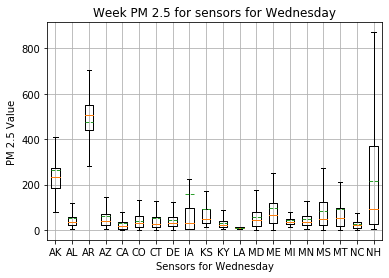

whiskers:  [114.0, 317.0, 5.0, 97.0, 320.0, 697.0, 8.0, 149.0, 0.0, 84.0, 3.0, 105.0, 9.0, 69.0, 8.0, 106.0, nan, nan, 7.0, 141.0, 10.0, 64.0, 3.0, 103.0, 7.0, 75.0, 5.0, 148.0, 13.0, 221.0, 22.0, 189.0, 4.0, 130.0, 11.0, 189.0, 6.0, 118.0, 7.0, 83.0, 4.0, 256.0]
caps:  [114.0, 317.0, 5.0, 97.0, 320.0, 697.0, 8.0, 149.0, 0.0, 84.0, 3.0, 105.0, 9.0, 69.0, 8.0, 106.0, nan, nan, 7.0, 141.0, 10.0, 64.0, 3.0, 103.0, 7.0, 75.0, 5.0, 148.0, 13.0, 221.0, 22.0, 189.0, 4.0, 130.0, 11.0, 189.0, 6.0, 118.0, 7.0, 83.0, 4.0, 256.0]
boxes:  [190.0, 20.0, 483.0, 27.0, 12.0, 18.0, 23.0, 26.0, nan, 24.0, 17.0, 13.0, 14.0, 33.0, 41.0, 42.0, 16.0, 33.0, 18.0, 25.0, 15.0]
medians:  [215.0, 35.0, 550.0, 44.0, 21.0, 38.0, 31.0, 41.0, nan, 36.0, 26.0, 22.0, 32.0, 51.0, 69.0, 61.0, 31.0, 60.0, 33.0, 41.0, 48.0]
means:  [212.34057971014494, 41.133352617876774, 504.62785752259435, 57.35412605588044, 28.031287365484257, 40.52720385674931, 38.27368421052632, 43.118505195843326, nan, 63.06507936507936, 90.603896103

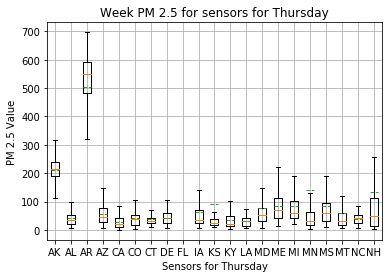

whiskers:  [95.0, 345.0, 1.0, 149.0, 398.0, 662.0, 3.0, 235.0, 0.0, 100.0, 1.0, 111.0, 2.0, 91.0, 2.0, 134.0, 3.0, 353.0, 203.0, 563.0, 1.0, 179.0, 1.0, 74.0, 2.0, 203.0, 1.0, 417.0, 76.0, 175.0, 2.0, 203.0, 3.0, 302.0, 1.0, 114.0, 2.0, 132.0, 2.0, 425.0]
caps:  [95.0, 345.0, 1.0, 149.0, 398.0, 662.0, 3.0, 235.0, 0.0, 100.0, 1.0, 111.0, 2.0, 91.0, 2.0, 134.0, 3.0, 353.0, 203.0, 563.0, 1.0, 179.0, 1.0, 74.0, 2.0, 203.0, 1.0, 417.0, 76.0, 175.0, 2.0, 203.0, 3.0, 302.0, 1.0, 114.0, 2.0, 132.0, 2.0, 425.0]
boxes:  [189.0, 15.0, 497.0, 23.0, 5.0, 21.0, 16.0, 19.0, 13.0, 338.0, 4.0, 12.0, 19.0, 27.0, 113.0, 13.0, 15.0, 12.0, 8.0, 20.0]
medians:  [216.0, 49.0, 521.0, 51.0, 20.0, 41.0, 29.0, 37.0, 47.5, 366.0, 27.0, 24.5, 50.0, 95.0, 129.0, 46.0, 44.0, 28.0, 28.0, 81.0]
means:  [215.13453868651953, 49.1311004784689, 530.0493058879847, 68.87300637958533, 30.249300838993207, 40.888888888888886, 34.80342902711324, 44.68637634838194, 98.86662679425838, 899.9706170421156, 50.32906325060048, 26.2057

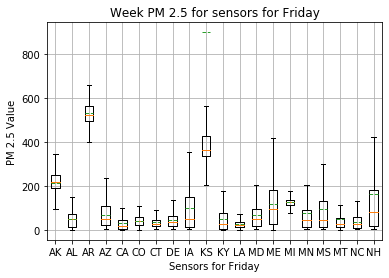

whiskers:  [73.0, 289.0, 0.0, 102.0, 384.0, 690.0, 2.0, 147.0, 0.0, 64.0, 1.0, 123.0, 0.0, 101.0, 1.0, 110.0, 4.0, 97.0, 12.0, 271.0, 1.0, 97.0, 0.0, 91.0, 1.0, 177.0, 1.0, 208.0, 24.0, 168.0, 2.0, 66.0, 2.0, 97.0, 1.0, 110.0, 1.0, 92.0, 6.0, 410.0]
caps:  [73.0, 289.0, 0.0, 102.0, 384.0, 690.0, 2.0, 147.0, 0.0, 64.0, 1.0, 123.0, 0.0, 101.0, 1.0, 110.0, 4.0, 97.0, 12.0, 271.0, 1.0, 97.0, 0.0, 91.0, 1.0, 177.0, 1.0, 208.0, 24.0, 168.0, 2.0, 66.0, 2.0, 97.0, 1.0, 110.0, 1.0, 92.0, 6.0, 410.0]
boxes:  [154.0, 12.0, 498.0, 12.0, 4.0, 6.0, 6.0, 10.0, 22.0, 30.0, 7.0, 4.0, 15.0, 14.0, 33.0, 9.0, 7.0, 7.0, 5.0, 12.0]
medians:  [185.0, 25.0, 520.0, 30.0, 10.0, 15.0, 13.0, 21.0, 37.0, 40.0, 14.0, 10.0, 37.0, 44.0, 45.0, 19.0, 24.0, 18.0, 20.0, 31.0]
means:  [181.9260765550239, 43.058745348219034, 534.7230861244019, 45.31853785900783, 30.810569812962157, 32.58834080717489, 41.288392500997205, 37.60100130605137, 49.39892344497608, 181.9434546862897, 27.85919425608297, 26.62227602905569, 57.227805

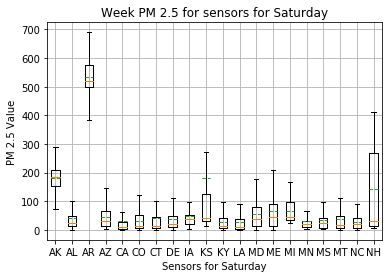

whiskers:  [62.0, 371.0, 0.0, 126.0, 384.0, 683.0, 0.0, 158.0, 0.0, 99.0, 1.0, 128.0, 1.0, 162.0, 1.0, 119.0, 1.0, 301.0, 16.0, 152.0, 0.0, 150.0, 1.0, 136.0, 0.0, 174.0, 0.0, 233.0, 38.0, 246.0, 3.0, 139.0, 1.0, 206.0, 0.0, 174.0, 0.0, 96.0, 3.0, 205.0]
caps:  [62.0, 371.0, 0.0, 126.0, 384.0, 683.0, 0.0, 158.0, 0.0, 99.0, 1.0, 128.0, 1.0, 162.0, 1.0, 119.0, 1.0, 301.0, 16.0, 152.0, 0.0, 150.0, 1.0, 136.0, 0.0, 174.0, 0.0, 233.0, 38.0, 246.0, 3.0, 139.0, 1.0, 206.0, 0.0, 174.0, 0.0, 96.0, 3.0, 205.0]
boxes:  [158.0, 16.0, 481.0, 10.0, 4.0, 9.0, 5.0, 9.0, 5.0, 27.0, 27.0, 4.0, 7.0, 13.0, 66.25, 17.0, 9.0, 19.0, 5.0, 10.0]
medians:  [203.0, 30.0, 522.5, 44.0, 10.0, 26.0, 28.0, 23.0, 39.0, 40.0, 55.0, 7.0, 24.0, 53.0, 100.0, 43.0, 35.0, 47.0, 14.0, 29.0]
means:  [211.55437383674555, 39.70753588516747, 483.4131920710868, 47.262491203377905, 29.568725532840364, 39.199042202933256, 64.69964100518548, 62.87578855775506, 68.68102073365232, 1844.6498422712934, 53.62782401902497, 31.569874476987

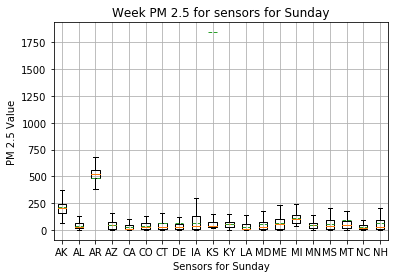

In [32]:
# Night each sensors - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

# data.tz_localize('UTC', level=8)

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = data[data.index.day_name() == day]
    # temp = temp.groupby("name")
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].between_time('01:01', '07:59').to_numpy().tolist())

    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()


# monday = data[(data.index.day_name() == 'Monday')].between_time('01:01', '07:59')['pm2_5']
# tuesday = data[data.index.day_name() == 'Tuesday'].between_time('01:01', '07:59')['pm2_5']
# wednesday = data[data.index.day_name() == 'Wednesday'].between_time('01:01', '07:59')['pm2_5']
# thursday = data[data.index.day_name() == 'Thursday'].between_time('01:01', '07:59')['pm2_5']
# friday = data[data.index.day_name() == 'Friday'].between_time('01:01', '07:59')['pm2_5']
# saturday = data[data.index.day_name() == 'Saturday'].between_time('01:01', '07:59')['pm2_5']
# sunday = data[data.index.day_name() == 'Sunday'].between_time('01:01', '07:59')['pm2_5']
# all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

# results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
# plt.savefig("./weely_hybrid_night_boxplot_pm_2_5/weely_hybrid_night_boxplot_pm_2_5.png", format='png')

# # print(results)
# print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
# print('caps: ', [item.get_ydata()[1] for item in results['caps']])
# print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
# print('medians: ', [item.get_ydata()[1] for item in results['medians']])
# print('means: ', [item.get_ydata()[1] for item in results['means']])
# print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data